# Generated Vs. Real Image Classification

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Data Preparation

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    RandomContrast,
    RandomRotation,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory

tf.config.list_physical_devices("GPU")

[]

### Load Data

In [4]:
train_img, test_img = image_dataset_from_directory(
    directory="images",
    label_mode="binary",
    image_size=(32, 32),
    seed=7324,
    validation_split=0.2,
    subset="both",
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


## Modeling

In [29]:
cnn1 = Sequential()
# Data augmentation
cnn1.add(RandomContrast(factor=0.5, seed=7324))
cnn1.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn1.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
    ),
)
cnn1.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    ),
)
cnn1.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn1.add(Flatten())
# Fully connected layers
cnn1.add(Dense(64, activation="relu"))
# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn1.add(Dense(1, activation="sigmoid"))

In [30]:
cnn1.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [31]:
cnn1_history = cnn1.fit(
    train_img,
    epochs=5,
    verbose=1,
    validation_data=test_img,
)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 88s 35ms/step - accuracy: 0.6852 - loss: 1.0724 - val_accuracy: 0.8070 - val_loss: 0.4204
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.7600 - loss: 0.5343 - val_accuracy: 0.7998 - val_loss: 0.4552
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 89s 36ms/step - accuracy: 0.7669 - loss: 0.5301 - val_accuracy: 0.8108 - val_loss: 0.4577
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 90s 36ms/step - accuracy: 0.7658 - loss: 0.5259 - val_accuracy: 0.8117 - val_loss: 0.4400
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 89s 36ms/step - accuracy: 0.7608 - loss: 0.5292 - val_accuracy: 0.8236 - val_loss: 0.4526


In [33]:
def plot_acc_loss(history_obj: tf.keras.callbacks.History) -> None:
    """Plot the accuracy and loss of the model.

    Parameters
    ----------
    history_obj : History
        The history object returned by the fit method of the model.

    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_obj.history["accuracy"], label="training")

    plt.ylabel("Accuracy %")
    plt.title("Training")
    plt.plot(history_obj.history["val_accuracy"], label="validation")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_obj.history["loss"], label="training")
    plt.ylabel("Training Loss")
    plt.xlabel("epochs")

    plt.plot(history_obj.history["val_loss"], label="validation")
    plt.xlabel("epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()

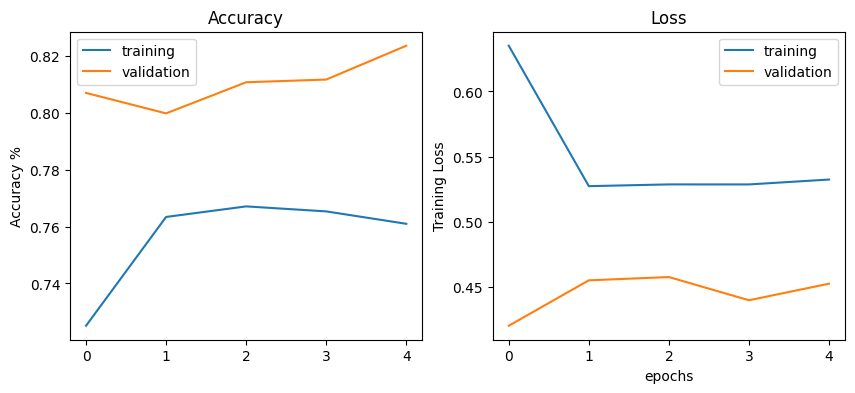

In [34]:
plot_acc_loss(cnn1_history)